## Modules/Dependencies

In [1]:
import setup
import numpy as np

In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import colabtools

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [3]:
# more common libraries for retrieving data
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import audioread
import json
import os
import itertools
from PIL import Image
import cv2

## Register Catalog and Visualize Data

In [4]:
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
ds_train = '/home/shared/cuzokwe/train/'
ds_val = '/home/shared/cuzokwe/val/'
audio_metadata = MetadataCatalog.get("salami_2020_img_train")

In [5]:
# register training set data and metadata
DatasetCatalog.register("salami_2020_img_train", lambda ds_train=ds_train: setup.get_audio_dicts(ds_train))
MetadataCatalog.get("salami_2020_img_train").thing_classes = ["chorus", "verse","intro"]

In [6]:
# register validation set data and metadata
DatasetCatalog.register("salami_2020_img_val", lambda ds_val=ds_val: setup.get_audio_dicts(ds_val))
MetadataCatalog.get("salami_2020_img_val").thing_classes = ["chorus", "verse","intro"]

In [20]:
# unregister dataset
DatasetCatalog.clear()

# show registered datasets
DatasetCatalog.list()

[]

In [7]:
dataset_dicts_train = setup.get_audio_dicts(ds_train)

In [8]:
dataset_dicts_val = setup.get_audio_dicts(ds_val)

In [8]:
import json
with open('data.json', 'w') as fp:
    json.dump(dataset_dicts_train, fp, indent=4)
    
    

(501, 501, 3)
/home/shared/cuzokwe/train//images/447.png


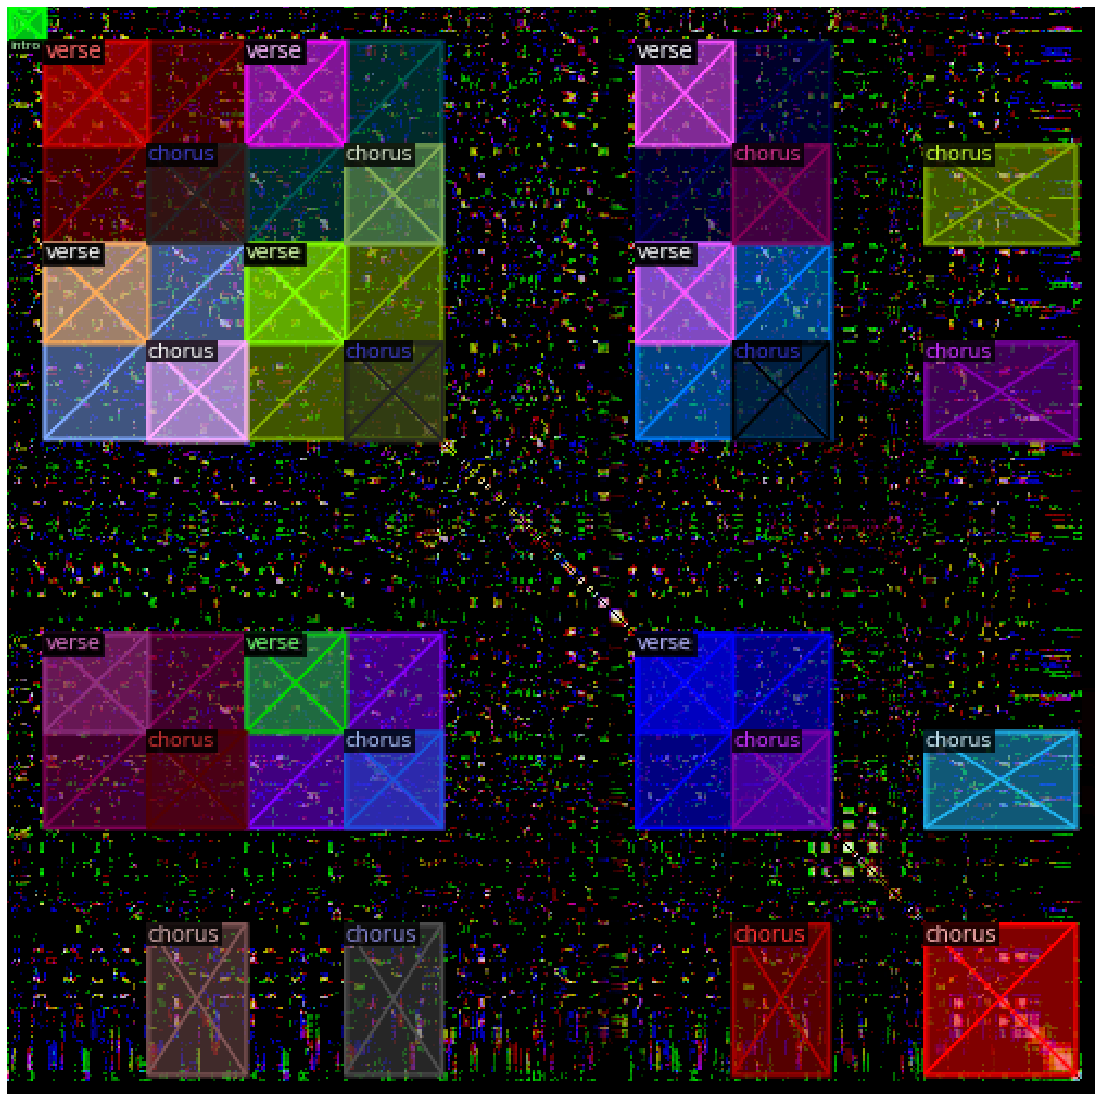

(1351, 1351, 3)
/home/shared/cuzokwe/train//images/28.png


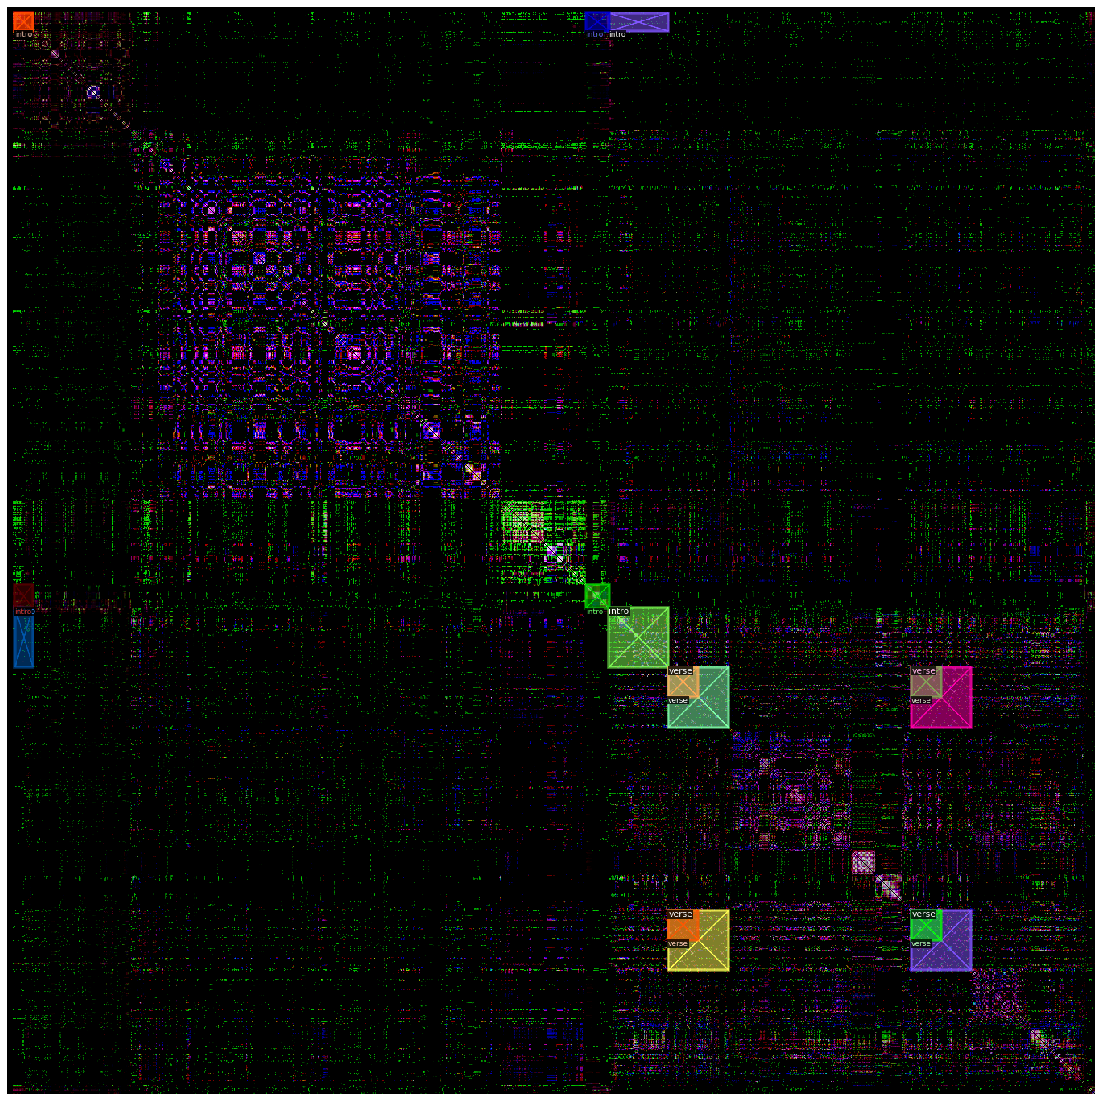

(626, 626, 3)
/home/shared/cuzokwe/train//images/767.png


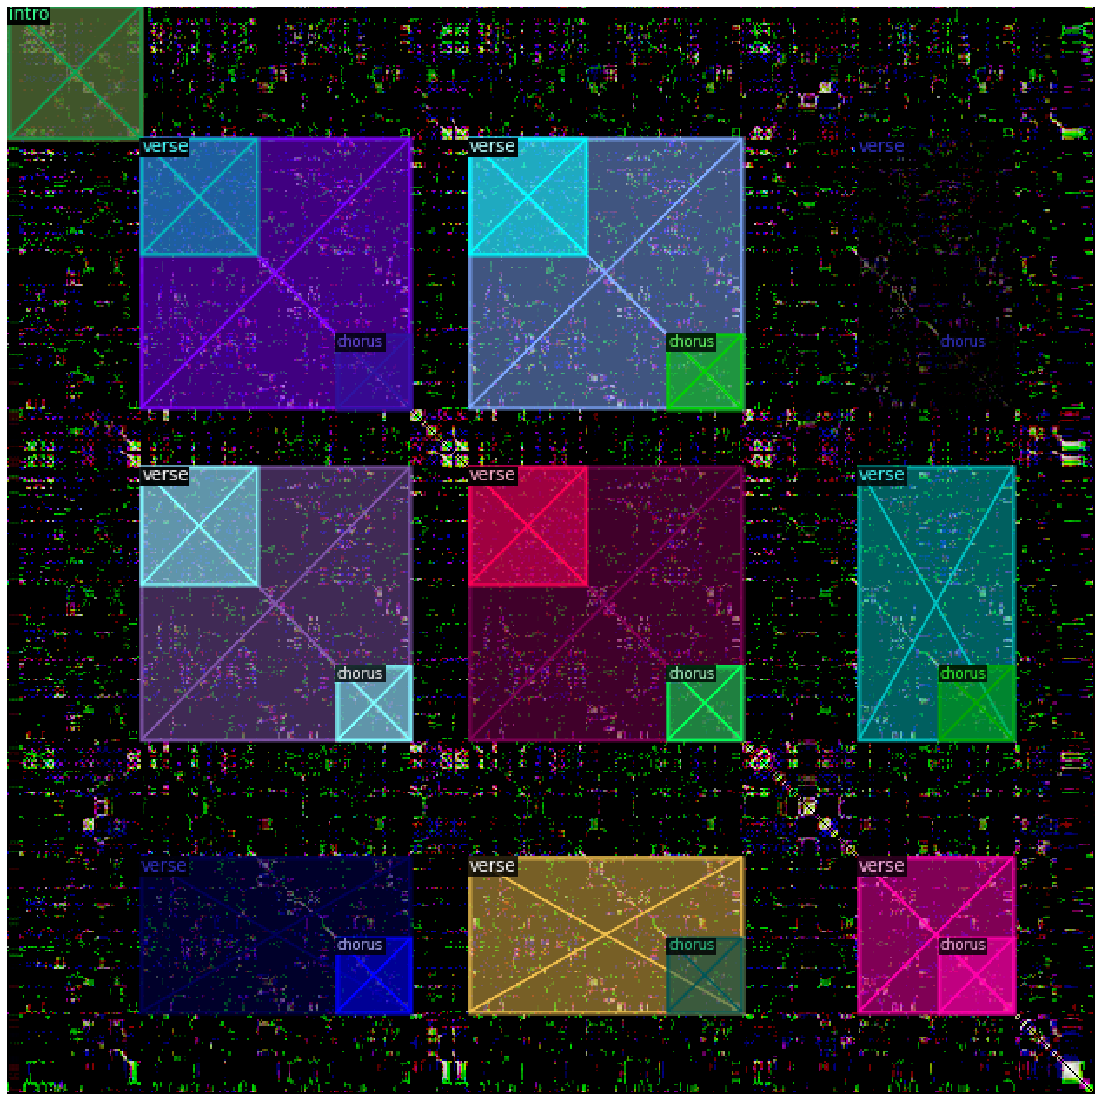

In [9]:
for d in random.sample(dataset_dicts_train, 3):
    img = cv2.imread(d["file_name"])
    print(img.shape)
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=audio_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20,20))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


## Train the Model

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("salami_2020_img_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0005  # pick a good LR
cfg.SOLVER.MAX_ITER = 15000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/24 12:00:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[04/24 12:01:11 d2.data.build]: Removed 72 images with no usable annotations. 417 images left.
[04/24 12:01:11 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   chorus   | 6201         |   verse    | 7305         |   intro    | 746          |
|            |              |            |              |            |              |
|   total    | 14252        |            |              |            |              |
[04/24 12:01:11 d2.data.common]: Serializing 417 elements to byte tensors and concatenating them all ...
[04/24 12:01:12 d2.data.common]: Serialized dataset takes 111.40 MiB
[04/24 12:01:12 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/24 12:01:12 d2.dat

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (12, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (12,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (3,) in the model! Skipped.


[04/24 12:01:14 d2.engine.train_loop]: Starting training from iteration 0
[04/24 12:01:19 d2.utils.events]:  eta: 0:57:27  iter: 19  total_loss: 4.679  loss_cls: 1.427  loss_box_reg: 0.183  loss_mask: 0.688  loss_rpn_cls: 2.264  loss_rpn_loc: 0.210  time: 0.2322  data_time: 0.0214  lr: 0.000010  max_mem: 2122M
[04/24 12:01:24 d2.utils.events]:  eta: 0:58:07  iter: 39  total_loss: 3.109  loss_cls: 1.142  loss_box_reg: 0.298  loss_mask: 0.683  loss_rpn_cls: 0.823  loss_rpn_loc: 0.218  time: 0.2354  data_time: 0.0170  lr: 0.000020  max_mem: 2122M
[04/24 12:01:29 d2.utils.events]:  eta: 0:58:07  iter: 59  total_loss: 2.517  loss_cls: 0.924  loss_box_reg: 0.323  loss_mask: 0.673  loss_rpn_cls: 0.432  loss_rpn_loc: 0.100  time: 0.2337  data_time: 0.0084  lr: 0.000030  max_mem: 2122M
[04/24 12:01:34 d2.utils.events]:  eta: 0:58:44  iter: 79  total_loss: 2.656  loss_cls: 0.824  loss_box_reg: 0.502  loss_mask: 0.657  loss_rpn_cls: 0.377  loss_rpn_loc: 0.189  time: 0.2399  data_time: 0.0294  lr:

[04/24 12:04:06 d2.utils.events]:  eta: 0:58:51  iter: 679  total_loss: 1.952  loss_cls: 0.547  loss_box_reg: 0.531  loss_mask: 0.327  loss_rpn_cls: 0.230  loss_rpn_loc: 0.131  time: 0.2492  data_time: 0.0082  lr: 0.000340  max_mem: 2446M
[04/24 12:04:11 d2.utils.events]:  eta: 0:58:42  iter: 699  total_loss: 1.802  loss_cls: 0.538  loss_box_reg: 0.493  loss_mask: 0.332  loss_rpn_cls: 0.225  loss_rpn_loc: 0.116  time: 0.2490  data_time: 0.0087  lr: 0.000350  max_mem: 2446M
[04/24 12:04:16 d2.utils.events]:  eta: 0:58:37  iter: 719  total_loss: 2.057  loss_cls: 0.632  loss_box_reg: 0.509  loss_mask: 0.315  loss_rpn_cls: 0.349  loss_rpn_loc: 0.167  time: 0.2490  data_time: 0.0146  lr: 0.000360  max_mem: 2446M
[04/24 12:04:21 d2.utils.events]:  eta: 0:58:32  iter: 739  total_loss: 2.108  loss_cls: 0.691  loss_box_reg: 0.610  loss_mask: 0.352  loss_rpn_cls: 0.246  loss_rpn_loc: 0.124  time: 0.2489  data_time: 0.0155  lr: 0.000370  max_mem: 2446M
[04/24 12:04:25 d2.utils.events]:  eta: 0:58

[04/24 12:06:53 d2.utils.events]:  eta: 0:56:35  iter: 1339  total_loss: 1.743  loss_cls: 0.516  loss_box_reg: 0.527  loss_mask: 0.299  loss_rpn_cls: 0.186  loss_rpn_loc: 0.127  time: 0.2502  data_time: 0.0117  lr: 0.000500  max_mem: 2558M
[04/24 12:06:58 d2.utils.events]:  eta: 0:56:30  iter: 1359  total_loss: 1.788  loss_cls: 0.633  loss_box_reg: 0.528  loss_mask: 0.289  loss_rpn_cls: 0.274  loss_rpn_loc: 0.152  time: 0.2504  data_time: 0.0292  lr: 0.000500  max_mem: 2558M
[04/24 12:07:03 d2.utils.events]:  eta: 0:56:25  iter: 1379  total_loss: 1.545  loss_cls: 0.468  loss_box_reg: 0.431  loss_mask: 0.307  loss_rpn_cls: 0.174  loss_rpn_loc: 0.101  time: 0.2504  data_time: 0.0096  lr: 0.000500  max_mem: 2558M
[04/24 12:07:08 d2.utils.events]:  eta: 0:56:20  iter: 1399  total_loss: 1.589  loss_cls: 0.501  loss_box_reg: 0.471  loss_mask: 0.307  loss_rpn_cls: 0.158  loss_rpn_loc: 0.112  time: 0.2503  data_time: 0.0092  lr: 0.000500  max_mem: 2558M
[04/24 12:07:13 d2.utils.events]:  eta: 

[04/24 12:09:40 d2.utils.events]:  eta: 0:53:55  iter: 1999  total_loss: 1.709  loss_cls: 0.534  loss_box_reg: 0.471  loss_mask: 0.288  loss_rpn_cls: 0.144  loss_rpn_loc: 0.102  time: 0.2502  data_time: 0.0348  lr: 0.000500  max_mem: 2567M
[04/24 12:09:45 d2.utils.events]:  eta: 0:53:50  iter: 2019  total_loss: 1.530  loss_cls: 0.471  loss_box_reg: 0.445  loss_mask: 0.266  loss_rpn_cls: 0.137  loss_rpn_loc: 0.104  time: 0.2502  data_time: 0.0090  lr: 0.000500  max_mem: 2567M
[04/24 12:09:50 d2.utils.events]:  eta: 0:53:46  iter: 2039  total_loss: 1.849  loss_cls: 0.590  loss_box_reg: 0.535  loss_mask: 0.293  loss_rpn_cls: 0.204  loss_rpn_loc: 0.159  time: 0.2502  data_time: 0.0105  lr: 0.000500  max_mem: 2567M
[04/24 12:09:55 d2.utils.events]:  eta: 0:53:40  iter: 2059  total_loss: 1.439  loss_cls: 0.475  loss_box_reg: 0.390  loss_mask: 0.261  loss_rpn_cls: 0.152  loss_rpn_loc: 0.100  time: 0.2503  data_time: 0.0213  lr: 0.000500  max_mem: 2567M
[04/24 12:10:00 d2.utils.events]:  eta: 

[04/24 12:12:27 d2.utils.events]:  eta: 0:51:15  iter: 2659  total_loss: 1.626  loss_cls: 0.501  loss_box_reg: 0.555  loss_mask: 0.264  loss_rpn_cls: 0.148  loss_rpn_loc: 0.124  time: 0.2505  data_time: 0.0283  lr: 0.000500  max_mem: 2567M
[04/24 12:12:32 d2.utils.events]:  eta: 0:51:11  iter: 2679  total_loss: 1.425  loss_cls: 0.512  loss_box_reg: 0.415  loss_mask: 0.256  loss_rpn_cls: 0.191  loss_rpn_loc: 0.110  time: 0.2504  data_time: 0.0096  lr: 0.000500  max_mem: 2567M
[04/24 12:12:37 d2.utils.events]:  eta: 0:51:04  iter: 2699  total_loss: 1.580  loss_cls: 0.561  loss_box_reg: 0.438  loss_mask: 0.276  loss_rpn_cls: 0.203  loss_rpn_loc: 0.121  time: 0.2504  data_time: 0.0171  lr: 0.000500  max_mem: 2567M
[04/24 12:12:43 d2.utils.events]:  eta: 0:51:00  iter: 2719  total_loss: 1.478  loss_cls: 0.502  loss_box_reg: 0.382  loss_mask: 0.272  loss_rpn_cls: 0.156  loss_rpn_loc: 0.121  time: 0.2504  data_time: 0.0111  lr: 0.000500  max_mem: 2567M
[04/24 12:12:48 d2.utils.events]:  eta: 

[04/24 12:15:15 d2.utils.events]:  eta: 0:48:45  iter: 3319  total_loss: 1.556  loss_cls: 0.473  loss_box_reg: 0.469  loss_mask: 0.268  loss_rpn_cls: 0.137  loss_rpn_loc: 0.119  time: 0.2508  data_time: 0.0316  lr: 0.000500  max_mem: 2567M
[04/24 12:15:20 d2.utils.events]:  eta: 0:48:40  iter: 3339  total_loss: 1.409  loss_cls: 0.436  loss_box_reg: 0.438  loss_mask: 0.257  loss_rpn_cls: 0.122  loss_rpn_loc: 0.112  time: 0.2508  data_time: 0.0090  lr: 0.000500  max_mem: 2567M
[04/24 12:15:25 d2.utils.events]:  eta: 0:48:35  iter: 3359  total_loss: 1.428  loss_cls: 0.454  loss_box_reg: 0.434  loss_mask: 0.267  loss_rpn_cls: 0.145  loss_rpn_loc: 0.114  time: 0.2507  data_time: 0.0100  lr: 0.000500  max_mem: 2567M
[04/24 12:15:30 d2.utils.events]:  eta: 0:48:31  iter: 3379  total_loss: 1.525  loss_cls: 0.480  loss_box_reg: 0.481  loss_mask: 0.264  loss_rpn_cls: 0.127  loss_rpn_loc: 0.108  time: 0.2507  data_time: 0.0089  lr: 0.000500  max_mem: 2567M
[04/24 12:15:35 d2.utils.events]:  eta: 

[04/24 12:18:03 d2.utils.events]:  eta: 0:45:53  iter: 3979  total_loss: 1.292  loss_cls: 0.375  loss_box_reg: 0.380  loss_mask: 0.249  loss_rpn_cls: 0.125  loss_rpn_loc: 0.099  time: 0.2510  data_time: 0.0129  lr: 0.000500  max_mem: 2567M
[04/24 12:18:09 d2.utils.events]:  eta: 0:45:48  iter: 3999  total_loss: 1.282  loss_cls: 0.415  loss_box_reg: 0.369  loss_mask: 0.230  loss_rpn_cls: 0.166  loss_rpn_loc: 0.118  time: 0.2511  data_time: 0.0273  lr: 0.000500  max_mem: 2567M
[04/24 12:18:14 d2.utils.events]:  eta: 0:45:44  iter: 4019  total_loss: 1.466  loss_cls: 0.459  loss_box_reg: 0.460  loss_mask: 0.293  loss_rpn_cls: 0.134  loss_rpn_loc: 0.151  time: 0.2511  data_time: 0.0114  lr: 0.000500  max_mem: 2567M
[04/24 12:18:19 d2.utils.events]:  eta: 0:45:38  iter: 4039  total_loss: 1.369  loss_cls: 0.442  loss_box_reg: 0.413  loss_mask: 0.241  loss_rpn_cls: 0.119  loss_rpn_loc: 0.090  time: 0.2511  data_time: 0.0102  lr: 0.000500  max_mem: 2567M
[04/24 12:18:24 d2.utils.events]:  eta: 

[04/24 12:20:51 d2.utils.events]:  eta: 0:43:16  iter: 4639  total_loss: 1.244  loss_cls: 0.388  loss_box_reg: 0.394  loss_mask: 0.238  loss_rpn_cls: 0.115  loss_rpn_loc: 0.102  time: 0.2511  data_time: 0.0105  lr: 0.000500  max_mem: 2567M
[04/24 12:20:56 d2.utils.events]:  eta: 0:43:13  iter: 4659  total_loss: 1.225  loss_cls: 0.404  loss_box_reg: 0.384  loss_mask: 0.201  loss_rpn_cls: 0.130  loss_rpn_loc: 0.075  time: 0.2511  data_time: 0.0095  lr: 0.000500  max_mem: 2567M
[04/24 12:21:01 d2.utils.events]:  eta: 0:43:08  iter: 4679  total_loss: 1.077  loss_cls: 0.336  loss_box_reg: 0.356  loss_mask: 0.212  loss_rpn_cls: 0.091  loss_rpn_loc: 0.105  time: 0.2511  data_time: 0.0108  lr: 0.000500  max_mem: 2567M
[04/24 12:21:07 d2.utils.events]:  eta: 0:43:01  iter: 4699  total_loss: 1.447  loss_cls: 0.452  loss_box_reg: 0.400  loss_mask: 0.234  loss_rpn_cls: 0.149  loss_rpn_loc: 0.125  time: 0.2511  data_time: 0.0112  lr: 0.000500  max_mem: 2567M
[04/24 12:21:12 d2.utils.events]:  eta: 

[04/24 12:23:42 d2.utils.events]:  eta: 0:40:15  iter: 5299  total_loss: 1.227  loss_cls: 0.353  loss_box_reg: 0.327  loss_mask: 0.220  loss_rpn_cls: 0.122  loss_rpn_loc: 0.114  time: 0.2510  data_time: 0.0230  lr: 0.000500  max_mem: 2567M
[04/24 12:23:47 d2.utils.events]:  eta: 0:40:13  iter: 5319  total_loss: 1.400  loss_cls: 0.425  loss_box_reg: 0.408  loss_mask: 0.250  loss_rpn_cls: 0.117  loss_rpn_loc: 0.091  time: 0.2510  data_time: 0.0104  lr: 0.000500  max_mem: 2567M
[04/24 12:23:52 d2.utils.events]:  eta: 0:40:06  iter: 5339  total_loss: 1.048  loss_cls: 0.342  loss_box_reg: 0.337  loss_mask: 0.200  loss_rpn_cls: 0.103  loss_rpn_loc: 0.083  time: 0.2510  data_time: 0.0086  lr: 0.000500  max_mem: 2567M
[04/24 12:23:57 d2.utils.events]:  eta: 0:40:01  iter: 5359  total_loss: 1.345  loss_cls: 0.405  loss_box_reg: 0.395  loss_mask: 0.224  loss_rpn_cls: 0.115  loss_rpn_loc: 0.091  time: 0.2510  data_time: 0.0296  lr: 0.000500  max_mem: 2567M
[04/24 12:24:02 d2.utils.events]:  eta: 

[04/24 12:26:29 d2.utils.events]:  eta: 0:37:27  iter: 5959  total_loss: 1.205  loss_cls: 0.366  loss_box_reg: 0.364  loss_mask: 0.224  loss_rpn_cls: 0.084  loss_rpn_loc: 0.091  time: 0.2510  data_time: 0.0302  lr: 0.000500  max_mem: 2567M
[04/24 12:26:34 d2.utils.events]:  eta: 0:37:23  iter: 5979  total_loss: 1.228  loss_cls: 0.384  loss_box_reg: 0.353  loss_mask: 0.212  loss_rpn_cls: 0.137  loss_rpn_loc: 0.104  time: 0.2510  data_time: 0.0119  lr: 0.000500  max_mem: 2567M
[04/24 12:26:39 d2.utils.events]:  eta: 0:37:17  iter: 5999  total_loss: 1.179  loss_cls: 0.409  loss_box_reg: 0.361  loss_mask: 0.225  loss_rpn_cls: 0.117  loss_rpn_loc: 0.129  time: 0.2509  data_time: 0.0091  lr: 0.000500  max_mem: 2567M
[04/24 12:26:44 d2.utils.events]:  eta: 0:37:14  iter: 6019  total_loss: 1.213  loss_cls: 0.389  loss_box_reg: 0.363  loss_mask: 0.219  loss_rpn_cls: 0.119  loss_rpn_loc: 0.081  time: 0.2509  data_time: 0.0095  lr: 0.000500  max_mem: 2567M
[04/24 12:26:50 d2.utils.events]:  eta: 

[04/24 12:29:17 d2.utils.events]:  eta: 0:34:41  iter: 6619  total_loss: 1.376  loss_cls: 0.405  loss_box_reg: 0.405  loss_mask: 0.217  loss_rpn_cls: 0.149  loss_rpn_loc: 0.134  time: 0.2510  data_time: 0.0312  lr: 0.000500  max_mem: 2567M
[04/24 12:29:22 d2.utils.events]:  eta: 0:34:36  iter: 6639  total_loss: 1.018  loss_cls: 0.328  loss_box_reg: 0.350  loss_mask: 0.206  loss_rpn_cls: 0.094  loss_rpn_loc: 0.063  time: 0.2510  data_time: 0.0090  lr: 0.000500  max_mem: 2567M
[04/24 12:29:27 d2.utils.events]:  eta: 0:34:32  iter: 6659  total_loss: 1.258  loss_cls: 0.385  loss_box_reg: 0.363  loss_mask: 0.218  loss_rpn_cls: 0.148  loss_rpn_loc: 0.077  time: 0.2510  data_time: 0.0086  lr: 0.000500  max_mem: 2567M
[04/24 12:29:32 d2.utils.events]:  eta: 0:34:29  iter: 6679  total_loss: 1.310  loss_cls: 0.411  loss_box_reg: 0.412  loss_mask: 0.236  loss_rpn_cls: 0.123  loss_rpn_loc: 0.117  time: 0.2510  data_time: 0.0167  lr: 0.000500  max_mem: 2567M
[04/24 12:29:37 d2.utils.events]:  eta: 

[04/24 12:32:05 d2.utils.events]:  eta: 0:32:06  iter: 7279  total_loss: 1.051  loss_cls: 0.309  loss_box_reg: 0.325  loss_mask: 0.206  loss_rpn_cls: 0.111  loss_rpn_loc: 0.092  time: 0.2511  data_time: 0.0110  lr: 0.000500  max_mem: 2567M
[04/24 12:32:10 d2.utils.events]:  eta: 0:32:02  iter: 7299  total_loss: 1.026  loss_cls: 0.321  loss_box_reg: 0.351  loss_mask: 0.225  loss_rpn_cls: 0.085  loss_rpn_loc: 0.079  time: 0.2511  data_time: 0.0254  lr: 0.000500  max_mem: 2567M
[04/24 12:32:15 d2.utils.events]:  eta: 0:31:57  iter: 7319  total_loss: 0.938  loss_cls: 0.280  loss_box_reg: 0.309  loss_mask: 0.181  loss_rpn_cls: 0.073  loss_rpn_loc: 0.064  time: 0.2511  data_time: 0.0085  lr: 0.000500  max_mem: 2567M
[04/24 12:32:20 d2.utils.events]:  eta: 0:31:52  iter: 7339  total_loss: 1.153  loss_cls: 0.391  loss_box_reg: 0.303  loss_mask: 0.208  loss_rpn_cls: 0.137  loss_rpn_loc: 0.107  time: 0.2511  data_time: 0.0183  lr: 0.000500  max_mem: 2567M
[04/24 12:32:25 d2.utils.events]:  eta: 

[04/24 12:34:55 d2.utils.events]:  eta: 0:29:35  iter: 7939  total_loss: 0.968  loss_cls: 0.286  loss_box_reg: 0.317  loss_mask: 0.202  loss_rpn_cls: 0.079  loss_rpn_loc: 0.076  time: 0.2514  data_time: 0.0106  lr: 0.000500  max_mem: 2567M
[04/24 12:35:00 d2.utils.events]:  eta: 0:29:29  iter: 7959  total_loss: 0.857  loss_cls: 0.246  loss_box_reg: 0.304  loss_mask: 0.198  loss_rpn_cls: 0.057  loss_rpn_loc: 0.069  time: 0.2514  data_time: 0.0089  lr: 0.000500  max_mem: 2567M
[04/24 12:35:05 d2.utils.events]:  eta: 0:29:23  iter: 7979  total_loss: 0.977  loss_cls: 0.254  loss_box_reg: 0.316  loss_mask: 0.210  loss_rpn_cls: 0.071  loss_rpn_loc: 0.094  time: 0.2514  data_time: 0.0190  lr: 0.000500  max_mem: 2567M
[04/24 12:35:10 d2.utils.events]:  eta: 0:29:18  iter: 7999  total_loss: 1.119  loss_cls: 0.310  loss_box_reg: 0.334  loss_mask: 0.200  loss_rpn_cls: 0.093  loss_rpn_loc: 0.098  time: 0.2514  data_time: 0.0115  lr: 0.000500  max_mem: 2567M
[04/24 12:35:15 d2.utils.events]:  eta: 

[04/24 12:37:45 d2.utils.events]:  eta: 0:27:05  iter: 8599  total_loss: 1.039  loss_cls: 0.287  loss_box_reg: 0.305  loss_mask: 0.184  loss_rpn_cls: 0.106  loss_rpn_loc: 0.092  time: 0.2517  data_time: 0.0124  lr: 0.000500  max_mem: 2567M
[04/24 12:37:50 d2.utils.events]:  eta: 0:27:00  iter: 8619  total_loss: 1.065  loss_cls: 0.331  loss_box_reg: 0.291  loss_mask: 0.184  loss_rpn_cls: 0.088  loss_rpn_loc: 0.088  time: 0.2517  data_time: 0.0188  lr: 0.000500  max_mem: 2567M
[04/24 12:37:55 d2.utils.events]:  eta: 0:26:56  iter: 8639  total_loss: 0.914  loss_cls: 0.250  loss_box_reg: 0.293  loss_mask: 0.208  loss_rpn_cls: 0.058  loss_rpn_loc: 0.096  time: 0.2517  data_time: 0.0117  lr: 0.000500  max_mem: 2567M
[04/24 12:38:01 d2.utils.events]:  eta: 0:26:50  iter: 8659  total_loss: 1.045  loss_cls: 0.259  loss_box_reg: 0.364  loss_mask: 0.205  loss_rpn_cls: 0.099  loss_rpn_loc: 0.091  time: 0.2517  data_time: 0.0187  lr: 0.000500  max_mem: 2567M
[04/24 12:38:06 d2.utils.events]:  eta: 

[04/24 12:40:35 d2.utils.events]:  eta: 0:24:13  iter: 9259  total_loss: 0.889  loss_cls: 0.261  loss_box_reg: 0.279  loss_mask: 0.170  loss_rpn_cls: 0.056  loss_rpn_loc: 0.064  time: 0.2520  data_time: 0.0111  lr: 0.000500  max_mem: 2567M
[04/24 12:40:40 d2.utils.events]:  eta: 0:24:07  iter: 9279  total_loss: 0.913  loss_cls: 0.265  loss_box_reg: 0.349  loss_mask: 0.194  loss_rpn_cls: 0.061  loss_rpn_loc: 0.086  time: 0.2520  data_time: 0.0116  lr: 0.000500  max_mem: 2567M
[04/24 12:40:45 d2.utils.events]:  eta: 0:24:02  iter: 9299  total_loss: 1.162  loss_cls: 0.332  loss_box_reg: 0.360  loss_mask: 0.210  loss_rpn_cls: 0.097  loss_rpn_loc: 0.098  time: 0.2520  data_time: 0.0123  lr: 0.000500  max_mem: 2567M
[04/24 12:40:51 d2.utils.events]:  eta: 0:23:58  iter: 9319  total_loss: 0.797  loss_cls: 0.198  loss_box_reg: 0.298  loss_mask: 0.171  loss_rpn_cls: 0.053  loss_rpn_loc: 0.070  time: 0.2520  data_time: 0.0380  lr: 0.000500  max_mem: 2567M
[04/24 12:40:56 d2.utils.events]:  eta: 

[04/24 12:43:25 d2.utils.events]:  eta: 0:21:22  iter: 9919  total_loss: 0.752  loss_cls: 0.246  loss_box_reg: 0.240  loss_mask: 0.168  loss_rpn_cls: 0.048  loss_rpn_loc: 0.061  time: 0.2522  data_time: 0.0111  lr: 0.000500  max_mem: 2567M
[04/24 12:43:30 d2.utils.events]:  eta: 0:21:17  iter: 9939  total_loss: 0.942  loss_cls: 0.260  loss_box_reg: 0.339  loss_mask: 0.183  loss_rpn_cls: 0.071  loss_rpn_loc: 0.069  time: 0.2522  data_time: 0.0176  lr: 0.000500  max_mem: 2567M
[04/24 12:43:36 d2.utils.events]:  eta: 0:21:13  iter: 9959  total_loss: 1.038  loss_cls: 0.310  loss_box_reg: 0.317  loss_mask: 0.185  loss_rpn_cls: 0.095  loss_rpn_loc: 0.101  time: 0.2522  data_time: 0.0475  lr: 0.000500  max_mem: 2567M
[04/24 12:43:41 d2.utils.events]:  eta: 0:21:08  iter: 9979  total_loss: 0.875  loss_cls: 0.232  loss_box_reg: 0.272  loss_mask: 0.183  loss_rpn_cls: 0.061  loss_rpn_loc: 0.062  time: 0.2522  data_time: 0.0194  lr: 0.000500  max_mem: 2567M
[04/24 12:43:49 d2.utils.events]:  eta: 

[04/24 12:46:20 d2.utils.events]:  eta: 0:18:38  iter: 10579  total_loss: 1.036  loss_cls: 0.267  loss_box_reg: 0.288  loss_mask: 0.196  loss_rpn_cls: 0.078  loss_rpn_loc: 0.092  time: 0.2524  data_time: 0.0107  lr: 0.000500  max_mem: 2567M
[04/24 12:46:25 d2.utils.events]:  eta: 0:18:33  iter: 10599  total_loss: 0.795  loss_cls: 0.162  loss_box_reg: 0.288  loss_mask: 0.174  loss_rpn_cls: 0.055  loss_rpn_loc: 0.063  time: 0.2524  data_time: 0.0395  lr: 0.000500  max_mem: 2567M
[04/24 12:46:30 d2.utils.events]:  eta: 0:18:27  iter: 10619  total_loss: 0.951  loss_cls: 0.280  loss_box_reg: 0.305  loss_mask: 0.177  loss_rpn_cls: 0.073  loss_rpn_loc: 0.086  time: 0.2524  data_time: 0.0108  lr: 0.000500  max_mem: 2567M
[04/24 12:46:35 d2.utils.events]:  eta: 0:18:22  iter: 10639  total_loss: 0.973  loss_cls: 0.270  loss_box_reg: 0.296  loss_mask: 0.210  loss_rpn_cls: 0.082  loss_rpn_loc: 0.077  time: 0.2524  data_time: 0.0119  lr: 0.000500  max_mem: 2567M
[04/24 12:46:41 d2.utils.events]:  e

[04/24 12:49:11 d2.utils.events]:  eta: 0:15:52  iter: 11239  total_loss: 0.815  loss_cls: 0.232  loss_box_reg: 0.313  loss_mask: 0.185  loss_rpn_cls: 0.044  loss_rpn_loc: 0.064  time: 0.2526  data_time: 0.0254  lr: 0.000500  max_mem: 2567M
[04/24 12:49:16 d2.utils.events]:  eta: 0:15:48  iter: 11259  total_loss: 0.878  loss_cls: 0.259  loss_box_reg: 0.262  loss_mask: 0.163  loss_rpn_cls: 0.050  loss_rpn_loc: 0.091  time: 0.2526  data_time: 0.0189  lr: 0.000500  max_mem: 2567M
[04/24 12:49:21 d2.utils.events]:  eta: 0:15:44  iter: 11279  total_loss: 1.014  loss_cls: 0.276  loss_box_reg: 0.306  loss_mask: 0.196  loss_rpn_cls: 0.065  loss_rpn_loc: 0.103  time: 0.2526  data_time: 0.0126  lr: 0.000500  max_mem: 2567M
[04/24 12:49:26 d2.utils.events]:  eta: 0:15:39  iter: 11299  total_loss: 0.754  loss_cls: 0.196  loss_box_reg: 0.267  loss_mask: 0.175  loss_rpn_cls: 0.043  loss_rpn_loc: 0.076  time: 0.2526  data_time: 0.0179  lr: 0.000500  max_mem: 2567M
[04/24 12:49:32 d2.utils.events]:  e

[04/24 12:52:01 d2.utils.events]:  eta: 0:13:07  iter: 11899  total_loss: 0.809  loss_cls: 0.219  loss_box_reg: 0.270  loss_mask: 0.156  loss_rpn_cls: 0.044  loss_rpn_loc: 0.075  time: 0.2528  data_time: 0.0193  lr: 0.000500  max_mem: 2567M
[04/24 12:52:07 d2.utils.events]:  eta: 0:13:02  iter: 11919  total_loss: 0.920  loss_cls: 0.259  loss_box_reg: 0.322  loss_mask: 0.171  loss_rpn_cls: 0.045  loss_rpn_loc: 0.090  time: 0.2528  data_time: 0.0125  lr: 0.000500  max_mem: 2567M
[04/24 12:52:12 d2.utils.events]:  eta: 0:12:56  iter: 11939  total_loss: 0.657  loss_cls: 0.146  loss_box_reg: 0.243  loss_mask: 0.153  loss_rpn_cls: 0.034  loss_rpn_loc: 0.059  time: 0.2528  data_time: 0.0109  lr: 0.000500  max_mem: 2567M
[04/24 12:52:17 d2.utils.events]:  eta: 0:12:51  iter: 11959  total_loss: 0.933  loss_cls: 0.245  loss_box_reg: 0.301  loss_mask: 0.176  loss_rpn_cls: 0.071  loss_rpn_loc: 0.072  time: 0.2528  data_time: 0.0163  lr: 0.000500  max_mem: 2567M
[04/24 12:52:22 d2.utils.events]:  e

[04/24 12:54:52 d2.utils.events]:  eta: 0:10:18  iter: 12559  total_loss: 0.626  loss_cls: 0.166  loss_box_reg: 0.236  loss_mask: 0.137  loss_rpn_cls: 0.029  loss_rpn_loc: 0.040  time: 0.2529  data_time: 0.0096  lr: 0.000500  max_mem: 2567M
[04/24 12:54:57 d2.utils.events]:  eta: 0:10:11  iter: 12579  total_loss: 0.937  loss_cls: 0.255  loss_box_reg: 0.339  loss_mask: 0.185  loss_rpn_cls: 0.070  loss_rpn_loc: 0.088  time: 0.2529  data_time: 0.0195  lr: 0.000500  max_mem: 2567M
[04/24 12:55:02 d2.utils.events]:  eta: 0:10:06  iter: 12599  total_loss: 0.881  loss_cls: 0.221  loss_box_reg: 0.306  loss_mask: 0.184  loss_rpn_cls: 0.041  loss_rpn_loc: 0.078  time: 0.2529  data_time: 0.0115  lr: 0.000500  max_mem: 2567M
[04/24 12:55:07 d2.utils.events]:  eta: 0:10:01  iter: 12619  total_loss: 0.731  loss_cls: 0.175  loss_box_reg: 0.238  loss_mask: 0.167  loss_rpn_cls: 0.034  loss_rpn_loc: 0.052  time: 0.2529  data_time: 0.0114  lr: 0.000500  max_mem: 2567M
[04/24 12:55:12 d2.utils.events]:  e

[04/24 12:57:43 d2.utils.events]:  eta: 0:07:31  iter: 13219  total_loss: 0.726  loss_cls: 0.197  loss_box_reg: 0.282  loss_mask: 0.151  loss_rpn_cls: 0.029  loss_rpn_loc: 0.066  time: 0.2531  data_time: 0.0149  lr: 0.000500  max_mem: 2567M
[04/24 12:57:48 d2.utils.events]:  eta: 0:07:26  iter: 13239  total_loss: 0.605  loss_cls: 0.157  loss_box_reg: 0.249  loss_mask: 0.150  loss_rpn_cls: 0.030  loss_rpn_loc: 0.067  time: 0.2531  data_time: 0.0176  lr: 0.000500  max_mem: 2567M
[04/24 12:57:53 d2.utils.events]:  eta: 0:07:21  iter: 13259  total_loss: 0.709  loss_cls: 0.179  loss_box_reg: 0.271  loss_mask: 0.156  loss_rpn_cls: 0.066  loss_rpn_loc: 0.057  time: 0.2531  data_time: 0.0109  lr: 0.000500  max_mem: 2567M
[04/24 12:57:58 d2.utils.events]:  eta: 0:07:15  iter: 13279  total_loss: 0.872  loss_cls: 0.224  loss_box_reg: 0.292  loss_mask: 0.166  loss_rpn_cls: 0.053  loss_rpn_loc: 0.089  time: 0.2531  data_time: 0.0121  lr: 0.000500  max_mem: 2567M
[04/24 12:58:03 d2.utils.events]:  e

In [39]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("salami_2020_img_val", )
predictor = DefaultPredictor(cfg)
print(cfg.OUTPUT_DIR)

./output


tensor(2, device='cuda:0')
{'instances': Instances(num_instances=19, image_height=714, image_width=714, fields=[pred_boxes: Boxes(tensor([[  1.8707,   0.9076,  41.5917,  41.0838],
        [124.7354, 120.6638, 245.4186, 242.3688],
        [597.3018, 239.9484, 642.0647, 283.6083],
        [357.5769, 201.4145, 405.1268, 250.2387],
        [197.8426, 355.0203, 246.2264, 403.4445],
        [282.1264, 121.5818, 356.9712, 198.1016],
        [241.9568, 243.8150, 276.9046, 278.4794],
        [128.3047, 283.3355, 198.3889, 355.4908],
        [483.1913, 119.7075, 603.9924, 244.6402],
        [428.7455,  41.7096, 478.7477, 126.8149],
        [239.0733, 599.4667, 280.9682, 650.1285],
        [  0.0000,   3.6031,  79.0463,  94.7496],
        [121.5880, 477.6725, 238.3324, 614.9144],
        [597.9930,  74.8261, 648.4780, 120.8093],
        [  2.2491,  32.8257,  76.5323,  81.2905],
        [272.7665, 477.7719, 403.9214, 635.3419],
        [ 79.4380, 241.2434, 118.2025, 277.5289],
        [482.8759, 4

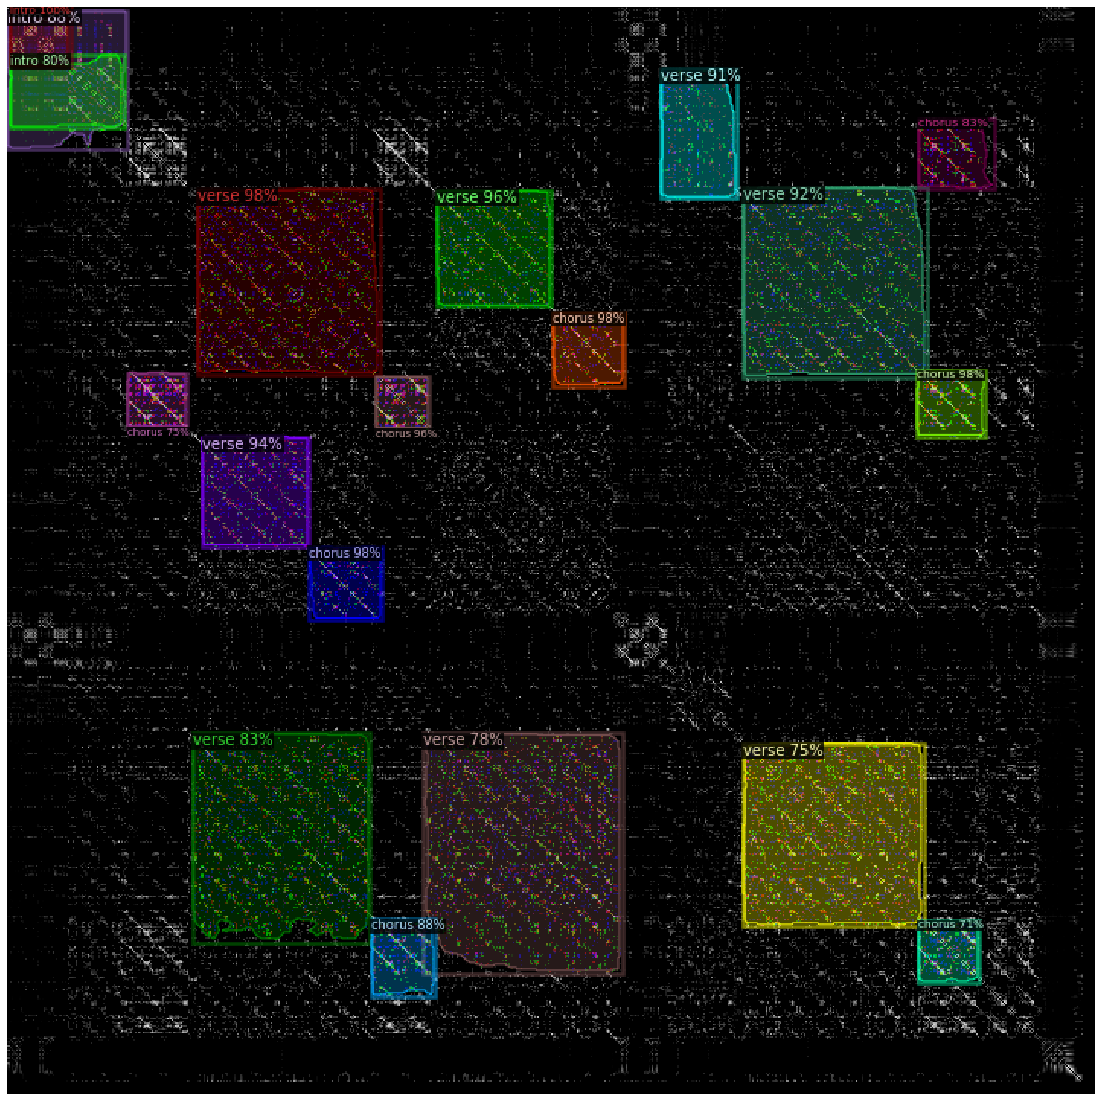

In [345]:
## fix this up (images), and try 

from detectron2.utils.visualizer import ColorMode
#for d in random.sample(dataset_dicts_val, 2):
im = cv2.imread(d["file_name"])
#print(d["file_name"])
outputs = predictor(im)
k = outputs["instances"]
j = k
print(outputs["instances"].pred_classes[0])#[1].item())
print(outputs)
v = Visualizer(im[:, :, ::-1],
               metadata=audio_metadata, 
               scale=1, 
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,20))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

(714, 714, 3)
/home/shared/cuzokwe/val//images/704.png


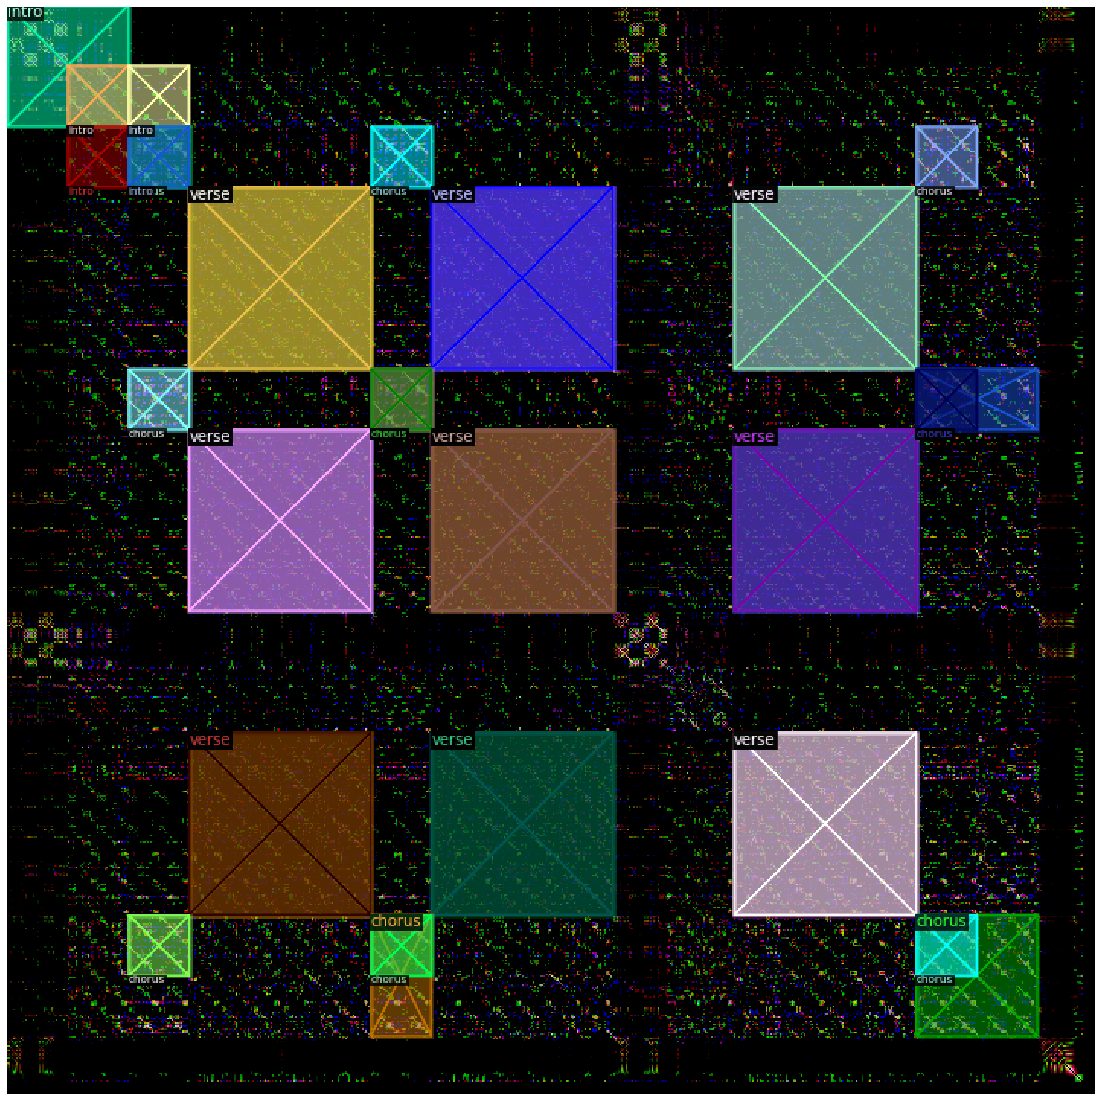

In [344]:
d = dataset_dicts_val[2]
img = cv2.imread(d["file_name"])
print(img.shape)
print(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=audio_metadata, scale=1)
vis = visualizer.draw_dataset_dict(d)
plt.figure(figsize=(20,20))
plt.imshow(vis.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

In [349]:
print(outputs)

{'instances': Instances(num_instances=19, image_height=714, image_width=714, fields=[pred_boxes: Boxes(tensor([[  1.8707,   0.9076,  41.5917,  41.0838],
        [124.7354, 120.6638, 245.4186, 242.3688],
        [597.3018, 239.9484, 642.0647, 283.6083],
        [357.5769, 201.4145, 405.1268, 250.2387],
        [197.8426, 355.0203, 246.2264, 403.4445],
        [282.1264, 121.5818, 356.9712, 198.1016],
        [241.9568, 243.8150, 276.9046, 278.4794],
        [128.3047, 283.3355, 198.3889, 355.4908],
        [483.1913, 119.7075, 603.9924, 244.6402],
        [428.7455,  41.7096, 478.7477, 126.8149],
        [239.0733, 599.4667, 280.9682, 650.1285],
        [  0.0000,   3.6031,  79.0463,  94.7496],
        [121.5880, 477.6725, 238.3324, 614.9144],
        [597.9930,  74.8261, 648.4780, 120.8093],
        [  2.2491,  32.8257,  76.5323,  81.2905],
        [272.7665, 477.7719, 403.9214, 635.3419],
        [ 79.4380, 241.2434, 118.2025, 277.5289],
        [482.8759, 484.1082, 601.7596, 604.3958

## Evaluation

In [366]:
""" compute the overlap accuracy of the diagonal image labels
 return [# of labels above threshold] & [average overlap] """
def diagonal_acc(dataset_dict, outputs, threshold, alllabels = 0):
    totalacc = 0
    numlabels = 0

    # find predicted bbox coordinates
    dpred = []
    for box in outputs["instances"].pred_boxes:
        tmp = []
        if abs(box[0].item() - box[1].item()) < 5 or alllabels:
            for x in box:
                tmp.append(x.item())
            dpred.append(tmp)

    # get diagonal dataset outline values (where x1 = y1)
    for prediction in dpred:
        acc = 0
        diff = 10000
        for gtruth in dataset_dict["annotations"]:
            if gtruth["bbox"][0] == gtruth["bbox"][1] or alllabels: # if diagonal entry, calculate smallest similarity
                for i in range(4):
                    tmp = abs(gtruth["bbox"][i] - prediction[i])

                if tmp < diff:
                    nearest_seg = gtruth["bbox"]
                    diff = tmp
 
        # calculate accuracy from nearest segment
        if prediction[2] < nearest_seg[0] and prediction[3] < nearest_seg[0]:
            acc = 0
        elif prediction[0] > nearest_seg[2] and prediction[1] < nearest_seg[2]:
            acc = 0
        else:
            overlaparea = (max(nearest_seg[0], prediction[0]) - min(nearest_seg[2],prediction[2])) * (max(nearest_seg[1], prediction[1]) - min(nearest_seg[3],prediction[3]))
            labelarea = (nearest_seg[2]-nearest_seg[0])*(nearest_seg[3]-nearest_seg[1])
            acc = overlaparea/labelarea
        
        if acc*100 > threshold:
            numlabels = numlabels + 1
            totalacc = totalacc + acc
    try:
        return numlabels, totalacc/numlabels*100
    except:
        print("No labels found. Lower threshold and try again.")
        return -1, -1


In [368]:
labels, avgacc = diagonal_acc(d, outputs, 0, 1)
print("num_labels",labels)
print(avgacc)

8
58.34349429430928


In [357]:
# compute the f1 score using diagonal(time) label entries. return precision, recall, and f1
def diagonal_precision(dataset_dict, outputs, threshold, alllabels = 0):
    correctlabels = 0
    numlabels = 0

    # find predicted bbox coordinates
    dpred = []
    i = 0
    for box in outputs["instances"].pred_boxes:
        tmp = []
        if abs(box[0].item() - box[1].item()) < 5 or alllabels:
            for x in box:
                tmp.append(x.item())
            tmp.append(outputs["instances"].pred_classes[i].item())
            dpred.append(tmp)
        i = i+1
        
    # get diagonal dataset outline values (where x1 = y1)
    for prediction in dpred:
        acc = 0
        diff = 10000
        for gtruth in dataset_dict["annotations"]:
            if gtruth["bbox"][0] == gtruth["bbox"][1] or alllabels:  # if diagonal entry, calculate smallest similarity
                for i in range(4):
                    tmp = abs(gtruth["bbox"][i] - prediction[i])

                if tmp < diff:
                    nearest_seg = gtruth["bbox"]
                    nearest_seg.append(gtruth["category_id"])
                    diff = tmp

        # calculate accuracy from nearest segment
        if prediction[2] < nearest_seg[0] and prediction[3] < nearest_seg[0]:
            acc = 0
        elif prediction[0] > nearest_seg[2] and prediction[1] < nearest_seg[2]:
            acc = 0
        else:
            overlaparea = (max(nearest_seg[0], prediction[0]) - min(nearest_seg[2], prediction[2])) * (
                        max(nearest_seg[1], prediction[1]) - min(nearest_seg[3], prediction[3]))
            labelarea = (nearest_seg[2] - nearest_seg[0]) * (nearest_seg[3] - nearest_seg[1])
            acc = overlaparea / labelarea

        if acc * 100 > threshold:
            numlabels = numlabels + 1
            if prediction[4] == nearest_seg[4]:
                correctlabels = correctlabels + 1
                
    return numlabels, correctlabels

In [358]:
labels, correct = diagonal_precision(d, outputs, 0)
print(labels)
print(correct)

[[1.8707469701766968, 0.9076198935508728, 41.59173583984375, 41.08379364013672, 2], [124.73541259765625, 120.66377258300781, 245.41859436035156, 242.36878967285156, 1], [241.95677185058594, 243.81504821777344, 276.90460205078125, 278.4794006347656, 0], [0.0, 3.603102922439575, 79.0462875366211, 94.74957275390625, 2], [482.8758850097656, 484.1082458496094, 601.7595825195312, 604.3958129882812, 1], [597.6491088867188, 600.59375, 638.0878295898438, 641.4403686523438, 0]]
6
6


In [363]:
def diagonal_recall(dataset_dict, outputs, threshold, alllabels = 0):
    correctlabels = 0
    numlabels = 0

    # find predicted bbox coordinates
    dpred = []
    i = 0
    for box in outputs["instances"].pred_boxes:
        tmp = []
        if abs(box[0].item() - box[1].item()) < 5 or alllabels:
            for x in box:
                tmp.append(x.item())
            tmp.append(outputs["instances"].pred_classes[i])
            dpred.append(tmp)
        i = i+1

    # get diagonal dataset outline values (where x1 = y1)
    for prediction in dpred:
        acc = 0
        diff = 10000
        gtruthcount = 0
        for gtruth in dataset_dict["annotations"]:
            if gtruth["bbox"][0] == gtruth["bbox"][1] or alllabels:  # if diagonal entry, calculate smallest similarity
                gtruthcount = gtruthcount + 1
                for i in range(4):
                    tmp = abs(gtruth["bbox"][i] - prediction[i])

                if tmp < diff:
                    nearest_seg = gtruth["bbox"]
                    nearest_seg.append(gtruth["category_id"])
                    diff = tmp

        # calculate accuracy from nearest segment
        if prediction[2] < nearest_seg[0] and prediction[3] < nearest_seg[0]:
            acc = 0
        elif prediction[0] > nearest_seg[2] and prediction[1] < nearest_seg[2]:
            acc = 0
        else:
            overlaparea = (max(nearest_seg[0], prediction[0]) - min(nearest_seg[2], prediction[2])) * \
                          (max(nearest_seg[1], prediction[1]) - min(nearest_seg[3], prediction[3]))
            labelarea = (nearest_seg[2] - nearest_seg[0]) * (nearest_seg[3] - nearest_seg[1])
            acc = overlaparea / labelarea

        if acc * 100 > threshold:
            numlabels = numlabels + 1
            if prediction[4] == nearest_seg[4]:
                correctlabels = correctlabels + 1

    return gtruthcount, correctlabels

In [364]:
gtruthlabels, correct = diagonal_recall(d, outputs, 0)
print(gtruthlabels)
print(correct)

36
7
